In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data split and standardizing(/scaling)
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold #je nachdem ob wir KFold brauchen, das weglassen
from sklearn.preprocessing import StandardScaler
# the 4 learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
# metrics
from sklearn.metrics import r2_score, mean_squared_error, roc_curve, confusion_matrix, auc
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score,classification_report, cohen_kappa_score, average_precision_score
from sklearn.metrics import accuracy_score

#Label encoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
# other
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Utility function to plot the diagonal line
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

# Multiple evaluation metrics for a provided classifier + Plots the ROC curce on given matplotlib axis

In [3]:
def evaluation_metrics(clf, y, X, ax, legend_entry='my legendEntry'):
    """
    compute multiple evaluation metrics for the provided classifier given the true labels
    and input features. Provides a plot of the roc curve on the given axis with the legend
    entry for this plot being specified, too.

    :param clf: classifier method
    :type clf: numpy array

    :param y: true class labels
    :type y: numpy array

    :param X: feature matrix
    :type X: numpy array

    :param ax: matplotlib axis to plot on
    :type legend_entry: matplotlib Axes

    :param legend_entry: the legend entry that should be displayed on the plot
    :type legend_entry: string

    :return: confusion matrix comprising the
             true positives (tp),
             true negatives  (tn),
             false positives (fp),
             and false negatives (fn)
    :rtype: four integers
    """

    # Get the label predictions
    y_test_pred = clf.predict(X)

    # Calculate the confusion matrix given the predicted and true labels
    tn, fp, fn, tp = confusion_matrix(y, y_test_pred).ravel()

    print(':) Successfully implemented the confusion matrix!')

    print('Confusion matrix:\n\t  |y_true = 0\t|y_true = 1')
    print('----------|-------------|------------')
    print('y_pred = 0|  ' + str(tn) + '\t\t|' + str(fn))
    print('y_pred = 1|  ' + str(fp) + '\t\t|' + str(tp))

    # Check for denominator of zero
    def safe_divide(numerator, denominator):
        return numerator / denominator if denominator != 0 else 0

    # Calculate the evaluation metrics
    precision = safe_divide(tp, (tp + fp))
    recall = safe_divide(tp, (tp + fn))
    f1_score = safe_divide((tp), (tp + (0.5 * (fn + fp))))
    specificity = safe_divide(tn, (tn + fp))
    accuracy = safe_divide((tp + tn), (tp + tn + fp + fn))

    # Get the roc curve using a sklearn function
    y_test_predict_proba = clf.predict_proba(X)
    fp_rates, tp_rates, _ = roc_curve(y, y_test_predict_proba[:,1])  # i want the predictioin probability for the class "1"

    # Calculate the area under the roc curve using a sklearn function
    roc_auc = auc(fp_rates, tp_rates)

    
    # Plot on the provided axis - feel free to make this plot nicer if # you want to.
    
    ax.plot(fp_rates, tp_rates, label='Fold {} (AUC = {:.3f})'.format(legend_entry, roc_auc))

    return [accuracy, precision, recall, specificity, f1_score, roc_auc]

#  Import data 

In [4]:
data = pd.read_csv(
    filepath_or_buffer='../data/healthcare-dataset-stroke-data.csv',
    index_col='id',
    dtype= {'gender':object, 'age':float, 'hypertension':bool, 'heart_disease':bool,
            'ever_married':object, 'work_type':object, 'Residence_type':object, 
            'avg_glucose_level':float, 'bmi':float, 'smoking_status':object, 'stroke':bool}
)

In [5]:
data['gender'] = pd.Categorical(data['gender'])
data['work_type'] = pd.Categorical(data['work_type'])
data['Residence_type'] = pd.Categorical(data['Residence_type'])
data['smoking_status'] = pd.Categorical(data['smoking_status'])

# change 'ever_married' to boolean
data['ever_married'] = data['ever_married'].map({'Yes': True, 'No': False})
data['ever_married'] = data['ever_married'].astype(bool)

In [6]:
sum(data['stroke']==True)

249

In [7]:
data.info()
print('There are ', data.shape[1], 'columns in the data.')
print('There are ', data.shape[0], 'rows in the data.')

<class 'pandas.core.frame.DataFrame'>
Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             5110 non-null   category
 1   age                5110 non-null   float64 
 2   hypertension       5110 non-null   bool    
 3   heart_disease      5110 non-null   bool    
 4   ever_married       5110 non-null   bool    
 5   work_type          5110 non-null   category
 6   Residence_type     5110 non-null   category
 7   avg_glucose_level  5110 non-null   float64 
 8   bmi                4909 non-null   float64 
 9   smoking_status     5110 non-null   category
 10  stroke             5110 non-null   bool    
dtypes: bool(4), category(4), float64(3)
memory usage: 200.3 KB
There are  11 columns in the data.
There are  5110 rows in the data.


In [8]:
# data.columns not necessary because already included in data.info()

# Datatypes -- df.info() and df.dtypes
# data.dtypes not necessary because already included in data.info()

# Missing Data -- df.isna().sum()
print('missing values:')
print(data.isna().sum())  ###bmi has 201 missing values
# Calculate the mean or median of the "bmi" feature
bmi_mean = data['bmi'].mean()
bmi_median = data['bmi'].median()
print(bmi_mean)
print(bmi_median)
# Replace the missing values with the mean or median
data['bmi'].fillna(bmi_mean, inplace=True)
print(data.isna().sum())

# Brief summary of extremes/means/medians -- df.describe()
print(data.describe())

# Check for duplicate rows -- df.duplicated()
print('sum of duplicated lines is:', data.duplicated().sum())  # marks all duplicates except the first occurence

missing values:
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
28.893236911794666
28.1
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64
               age  avg_glucose_level          bmi
count  5110.000000        5110.000000  5110.000000
mean     43.226614         106.147677    28.893237
std      22.612647          45.283560     7.698018
min       0.080000          55.120000    10.300000
25%      25.000000          77.245000    23.800000
50%      45.000000          91.885000    28.400000
75%      61.000000         114.090000    32.80000

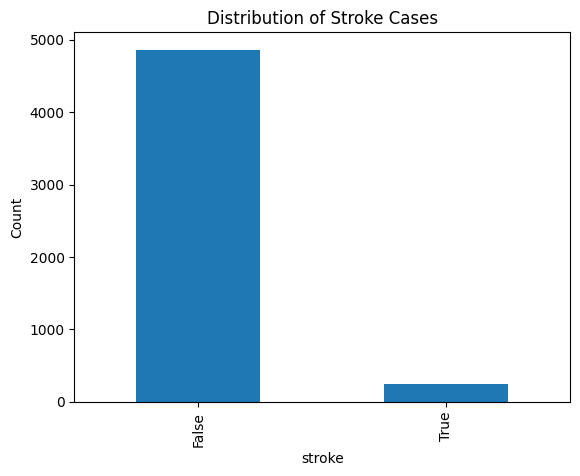

In [9]:
ax = data['stroke'].value_counts().plot(kind='bar')
ax.set_title('Distribution of Stroke Cases')
ax.set_ylabel('Count')

plt.savefig('../output/Distribution of Strokecases.png')
plt.show()

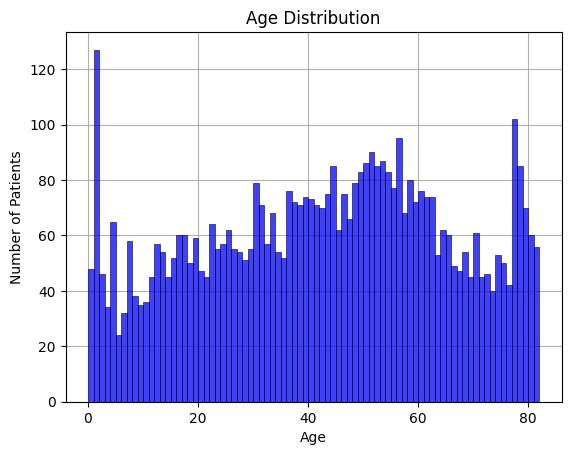

In [10]:
age_distribution = sns.histplot(x = data['age'], color = 'blue', bins=1, binwidth=1)
age_distribution.set(xlabel = 'Age', ylabel = 'Number of Patients', title = 'Age Distribution')
plt.grid(True)
age_distribution.set_axisbelow(True)
age_distribution.set_zorder(-1)

plt.savefig('../output/Age Distribution.png')

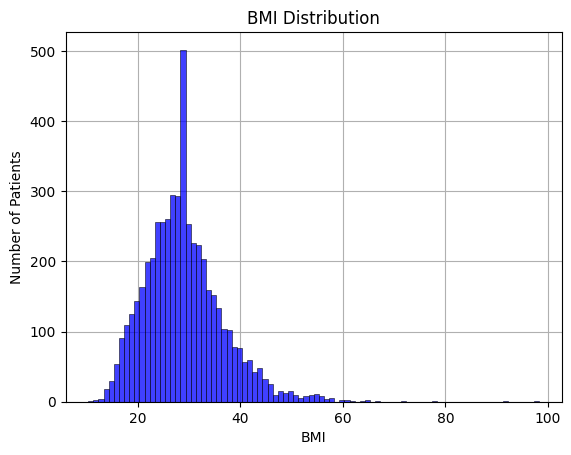

In [11]:
bmi_distribution = sns.histplot(x = data['bmi'], color = 'blue', bins=1, binwidth=1)
bmi_distribution.set(xlabel = 'BMI', ylabel = 'Number of Patients', title = 'BMI Distribution')
plt.grid(True)
bmi_distribution.set_axisbelow(True)
bmi_distribution.set_zorder(-1)
plt.savefig('../output/BMI Distribution.png')

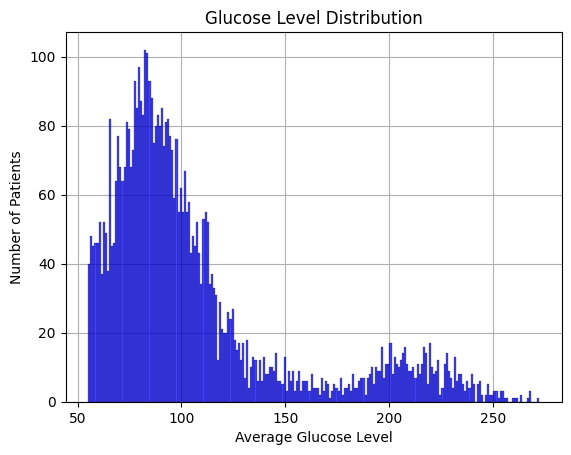

In [12]:
glucose_level_distribution = sns.histplot(x = data['avg_glucose_level'], color = 'blue', bins=1, binwidth=1)
glucose_level_distribution.set(xlabel = 'Average Glucose Level', ylabel = 'Number of Patients', title = 'Glucose Level Distribution')
plt.grid(True)
glucose_level_distribution.set_axisbelow(True)
glucose_level_distribution.set_zorder(-1)
plt.savefig('../output/Glucose Level Distribution.png')

In [13]:
data['gender'].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

Because we only have 1 instance of "other" gender we will remove it to reduce the dimension of age 

In [14]:

data = data[data['gender'] != 2]


Much more females as compared to males

In [15]:
data['smoking_status'].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

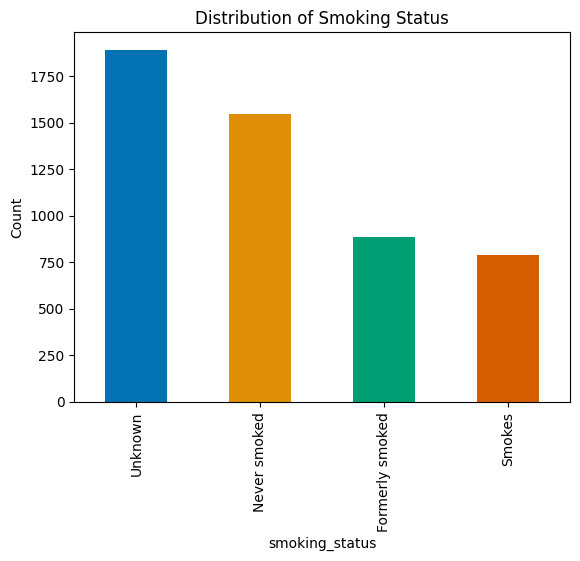

In [16]:
colors = sns.color_palette("colorblind")
ax = data['smoking_status'].value_counts().plot(kind="bar", color=colors)
ax.set_title('Distribution of Smoking Status')
ax.set_ylabel('Count')
# Get the category names
category_names = ['Unknown', 'Never smoked', 'Formerly smoked', 'Smokes']

# Set the x-tick labels to the category names
ax.set_xticklabels(category_names)

plt.savefig('../output/Smoking Status Distribution.png')
plt.show()

In [17]:
data['Residence_type'].value_counts()

Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64

In [18]:
# Identify the categorical (cat_cols), numerical features (num_cols) and boolean features(boolean_cols)
num_cols = ['age', 'avg_glucose_level', 'bmi']
cate_cols = ['gender', 'work_type', 'Residence_type', 'smoking_status']
boolean_cols = ['hypertension', 'heart_disease', 'ever_married', 'stroke']

# Convert boolean columns to integers (0 or 1)
data[boolean_cols] = data[boolean_cols].astype(int)

# This replaces the categorical columns with their corresponding encoded numerical values
label_encoder = LabelEncoder()
for col in cate_cols:
    data[col] = label_encoder.fit_transform(data[col])
# is this really better than one-hot encoding ? since there is no order in our categorical variables it should not matter which one we use?

# This helps that no more columns are created than before
columns_to_keep = num_cols + cate_cols + boolean_cols
data_e = data[columns_to_keep]

In [19]:
# onehot encoding for categorical feature
data = pd.get_dummies(data)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
51676,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
31112,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
60182,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
1665,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


In [20]:
# Assuming your target variable is named 'stroke'
class_counts = data['stroke'].value_counts()
class_proportions = data['stroke'].value_counts(normalize=True)

print("Class Counts:")
print(class_counts)

print("\nClass Proportions:")
print(class_proportions)
print("% of people who actualy got a stroke : ",(data['stroke'].value_counts()[1]/data['stroke'].value_counts().sum()).round(3)*100)



Class Counts:
stroke
0    4861
1     249
Name: count, dtype: int64

Class Proportions:
stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64
% of people who actualy got a stroke :  4.9


# Seperate feature and target

In [21]:
X = data.copy().drop(columns='stroke')
y = data['stroke']

# SMOTE 

In [22]:
sm = SMOTE(random_state=42)
X_sm , y_sm = sm.fit_resample(X,y)

print(f'''Shape of X before SMOTE:{X.shape}
Shape of X after SMOTE:{X_sm.shape}''',"\n\n")

print(f'''Target Class distributuion before SMOTE:\n{y.value_counts(normalize=True)}
Target Class distributuion after SMOTE :\n{y_sm.value_counts(normalize=True)}''')
     

Shape of X before SMOTE:(5110, 10)
Shape of X after SMOTE:(9722, 10) 


Target Class distributuion before SMOTE:
stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64
Target Class distributuion after SMOTE :
stroke
1    0.5
0    0.5
Name: proportion, dtype: float64


In [23]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_classifier = RandomForestClassifier(random_state=1)
grid_search = GridSearchCV(rf_classifier, param_grid, cv=kfold)
grid_search.fit(X_sm, y_sm)
best_params = grid_search.best_params_

# Print the best parameters for each parameter in the param_grid
for param_name in param_grid:
    print(f"Best {param_name}: {grid_search.best_params_[param_name]}")

Best n_estimators: 300
Best max_depth: None
Best min_samples_split: 5
Best max_features: auto


:) Successfully implemented the confusion matrix!
Confusion matrix:
	  |y_true = 0	|y_true = 1
----------|-------------|------------
y_pred = 0|  898		|44
y_pred = 1|  74		|929
:) Successfully implemented the confusion matrix!
Confusion matrix:
	  |y_true = 0	|y_true = 1
----------|-------------|------------
y_pred = 0|  913		|41
y_pred = 1|  60		|931
:) Successfully implemented the confusion matrix!
Confusion matrix:
	  |y_true = 0	|y_true = 1
----------|-------------|------------
y_pred = 0|  901		|47
y_pred = 1|  71		|925
:) Successfully implemented the confusion matrix!
Confusion matrix:
	  |y_true = 0	|y_true = 1
----------|-------------|------------
y_pred = 0|  905		|28
y_pred = 1|  67		|944
:) Successfully implemented the confusion matrix!
Confusion matrix:
	  |y_true = 0	|y_true = 1
----------|-------------|------------
y_pred = 0|  889		|35
y_pred = 1|  83		|937


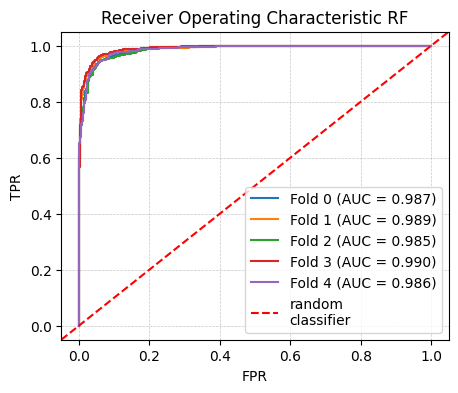

In [24]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
# Prepare the performance overview data frame
data_performance = pd.DataFrame(columns=['fold', 'clf', 'accuracy', 'precision', 'recall', 'specificity', 'F1', 'roc_auc'])

all_importance = pd.DataFrame(index=range(0, 5), columns=X.columns)
# Use this counter to save your performance metrics for each cross-validation fold
# also plot the roc curve for each model and fold into a joint subplot
fold = 0
fig, ax = plt.subplots( figsize=(5, 4))
model_names = ['Random Forest']  # Specify model names here
for train_index, test_index in kfold.split(X_sm, y_sm):
    X_train, X_test = X_sm.iloc[train_index], X_sm.iloc[test_index]
    y_train, y_test = y_sm.iloc[train_index], y_sm.iloc[test_index]

    # ----------------------------  Standardizing/Scaling  ---------------------------------
    sc = StandardScaler()
    # create copies like in the tutorial to avoid inplace operations
    X_train_sc, X_test_sc = X_train.copy(), X_test.copy()

    X_train_sc[num_cols] = sc.fit_transform(X_train[num_cols])
    X_test_sc[num_cols] = sc.transform(X_test[num_cols])

    # ––––––––––––––––––––––––––––––  Random Forest  ––––––––––––––––––––––––––––––
    
    
    rf_classifier = RandomForestClassifier(random_state=1, **best_params)
    
    #Fit the model
    rf_classifier.fit(X_train_sc, y_train)


    
    #Make prediction using the final model 
    y_pred = rf_classifier.predict(X_test)
    
    #Calculate accuracy and store it 
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    

    # ––––––––––––––––––––––––––––––  Evaluate your classifiers  –––––––––––––––
    eval_metrics_rf = evaluation_metrics(rf_classifier, y_test, X_test_sc, ax, legend_entry=str(fold))
    all_importance.loc[fold] = rf_classifier.feature_importances_
    data_performance.loc[len(data_performance), :] = [fold, 'Random Forest'] + eval_metrics_rf

    
    # increase counter for folds
    fold += 1

mean_accuracy = np.mean(accuracy_scores)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
add_identity(ax, color="r", ls="--", label='random\nclassifier')
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
ax.set_title("Receiver Operating Characteristic RF")
ax.legend(loc="lower right")
plt.savefig('../output/Random Forest - Receiver Operating Characteristic .png')

In [25]:
data_performance 

,fold,clf,accuracy,precision,recall,specificity,F1,roc_auc
0,0,Random Forest,0.939332,0.926221,0.954779,0.923868,0.940283,0.986595
1,1,Random Forest,0.948072,0.939455,0.957819,0.938335,0.948548,0.988644
2,2,Random Forest,0.9393,0.928715,0.951646,0.926955,0.940041,0.985208
3,3,Random Forest,0.951132,0.933729,0.971193,0.93107,0.952093,0.98968
4,4,Random Forest,0.9393,0.918627,0.963992,0.914609,0.940763,0.98637


In [26]:
data_performance.groupby(by = 'clf').agg(['mean', 'std'])

fold            accuracy          precision              recall   
              mean       std      mean      std      mean       std      mean   
clf                                                                             
Random Forest  2.0  1.581139  0.943427  0.00574   0.92935  0.007849  0.959886  \

                        specificity                 F1           roc_auc   
                    std        mean      std      mean       std    mean   
clf                                                                        
Random Forest  0.007794    0.926967  0.00878  0.944346  0.005602  0.9873  \

                         
                    std  
clf                      
Random Forest  0.001817

In [27]:
display(all_importance)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0.028309,0.438407,0.015162,0.012814,0.020621,0.074706,0.030122,0.186611,0.143128,0.050121
1,0.028312,0.435464,0.015444,0.012293,0.019948,0.075376,0.028789,0.182517,0.150084,0.051773
2,0.028087,0.434544,0.015268,0.011324,0.021347,0.074067,0.027666,0.181025,0.150977,0.055694
3,0.025802,0.440584,0.017649,0.012036,0.020265,0.076567,0.025943,0.179319,0.147607,0.054229
4,0.025709,0.444624,0.015603,0.012285,0.020979,0.073469,0.027166,0.182591,0.146337,0.051237


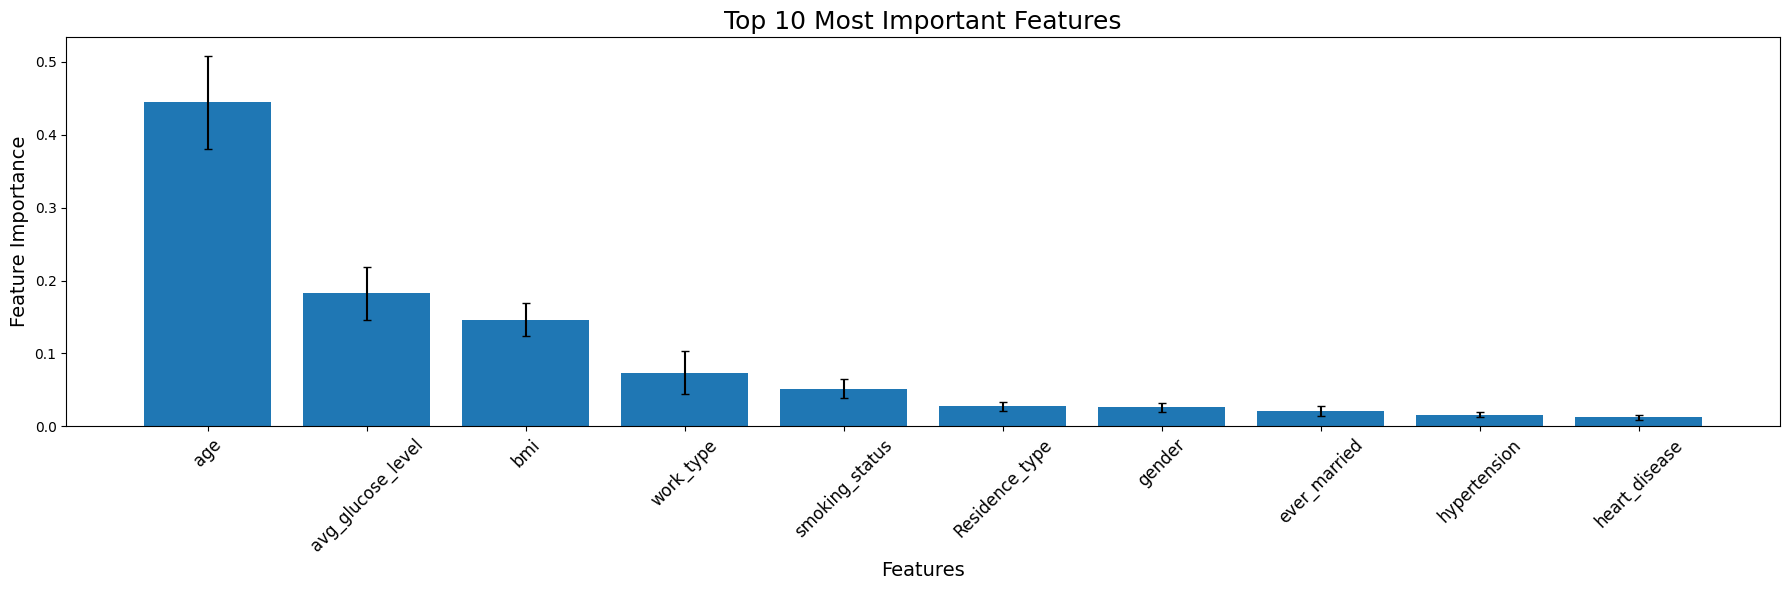

In [31]:
feature_importance = rf_classifier.feature_importances_
std_importance = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)



# Sort the feature importance in descending order and select the top 10 features
top_features_indices = np.argsort(feature_importance)[::-1][:10]
top_features = X.columns[top_features_indices]
top_importance = feature_importance[top_features_indices]
top_std_importance = std_importance[top_features_indices]

# Plot the top 10 most important features
plt.figure(figsize=(18, 6))
plt.bar(top_features, top_importance)
plt.errorbar(top_features, top_importance, yerr=top_std_importance, fmt='none', color='black', capsize=3)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Feature Importance', fontsize=14)
plt.title('Top 10 Most Important Features', fontsize=18)
plt.xticks(rotation=45, ha='center', fontsize=12)
plt.ylim(bottom=0)  # Set the bottom limit of the y-axis to 0
plt.tight_layout()  # Adjust spacing between subplots and labels

# Store feature importance and standard deviation in the performance overview data frame
data_performance['feature_importance'] = pd.Series(feature_importance)
data_performance['std_importance'] = pd.Series(std_importance)
plt.savefig('../output/Top 10 Most Important Features (RF).png')
plt.show()